In [15]:
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

import twitter_credentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets


In [17]:
# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

In [18]:
# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)

In [19]:
# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)


In [20]:
class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

In [21]:
 if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="realDonaldTrump", count=200)

    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    
    print(df.head(10))

                                              Tweets                   id  \
0  But Chris, you don’t see any activity from Chi...  1306749921173762049   
1  ...And I look at them as a bunch of well funde...  1306746265724530688   
2  On Air Force One heading to Wisconsin. Biden r...  1306738755894566912   
3  Bob Woodward’s badly written book is very bori...  1306735337423605760   
4  Happy #ConstitutionDay! https://t.co/DoahM18Iu...  1306728886902968321   
5                            https://t.co/aK0nvetAHK  1306726324480946176   
6  Volunteer to be a Trump Election Poll Watcher....  1306704659277635587   
7  The Democrats are just ANGRY that the vaccine ...  1306695488167718912   
8  I would like to extend best wishes and a very ...  1306693977723342848   
9  RT @WhiteHouse: Today, we are seeing the resul...  1306690886634483712   

   len                date              source  likes  retweets  
0  140 2020-09-18 00:20:34  Twitter for iPhone  21584      7667  
1  144 2020-09-18 00

In [22]:
df.to_csv(r'C:\Work\Twitter API\kangana_tweets.csv', index = False)

In [23]:
# Get average length over all tweets:
print(np.mean(df['len']))

109.32


In [24]:
# Get the number of likes for the most liked tweet:
print(np.max(df['likes']))

300213


In [25]:
# Get the number of retweets for the most retweeted tweet:
print(np.max(df['retweets']))

61956


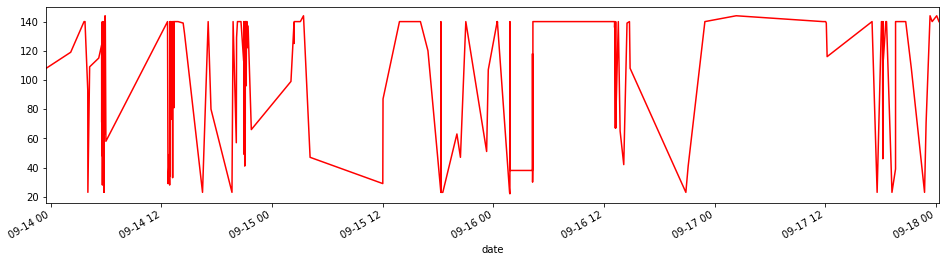

In [26]:
 # Time Series
time_likes = pd.Series(data=df['len'].values, index=df['date'])
time_likes.plot(figsize=(16, 4), color='r')
plt.show()

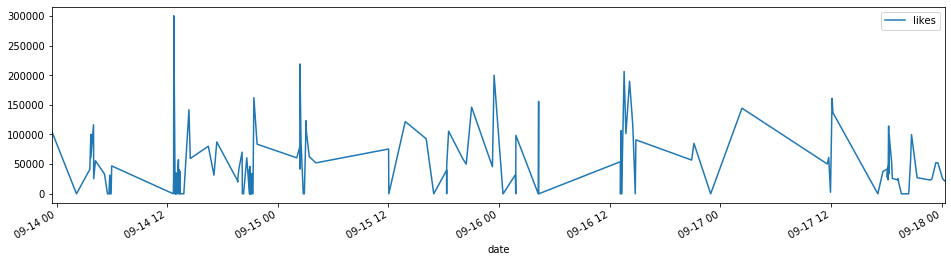

In [29]:
 # Layered Time Series:
time_likes = pd.Series(data=df['likes'].values, index=df['date'])
time_likes.plot(figsize=(16, 4), label="likes", legend=True)

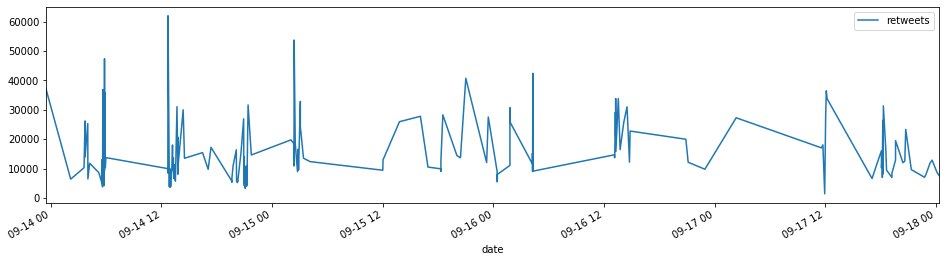

In [30]:
time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)
plt.show()